# <center> <font face="Times New Roman"> Statistics of Bird Migration </font></center>

<center> <font face="Times New Roman"> Gracy Whelihan, vgw3869@nyu.edu </font></center> 
<center> <font face="Times New Roman"> Sheeran Yan, zy2053@nyu.edu </font></center>

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()
%matplotlib inline

In [49]:
from sklearn.cluster import KMeans

## <font face="Times New Roman">Read Full Data from 2000 to 2021</font>

**<font face="Times New Roman">Read data from text file</font>**  
TODO: Text Preprocssing: Datetime Index

In [50]:
# main data from year 2018 to 2022
txt_migration_total = open("data/ebird_US-NY__total.txt", "r")

**<font face="Times New Roman">Parse data from text file line by line</font>**

In [51]:
dict_migration_total = dict()
for line in txt_migration_total:
    line_list = line.split("\t")
    if line_list != ['\n'] and len(line_list) > 2: 
        dict_migration_total[line_list[0]] = line_list[1:-1]

**<font face="Times New Roman">Create DataFrame</font>**

In [52]:
df_migration_total = pd.DataFrame(dict_migration_total)
df_migration_total.rename(columns={'': 'week'}, inplace=True)

**<font face="Times New Roman">Data preprocessing</font>**

In [54]:
# preprocess week
for i in range(len(df_migration_total.week)):
    if df_migration_total.week.iloc[i] == '':
        preprocessed_data = df_migration_total.week.iloc[i - 1].split('_')[0] + '_' + str(i % 4 + 1)
        df_migration_total.week.iloc[i] = preprocessed_data
    else:
        df_migration_total.week.iloc[i] = df_migration_total.week.iloc[i] + '_' + '1'

In [55]:
# lower column name 
df_migration_total.columns = [
    col.lower().strip() for col in df_migration_total.columns
]

# set month_week as index
df_migration_total.set_index('week', inplace=True)

# coerce type string to type float
df_migration_total = df_migration_total.astype(float)

In [56]:
df_migration_total.shape

(48, 726)

There were only 48 obervations per year or four times per week without specified date.  
In further data processing, we assume that four observations within a month are fixed on 7th, 14th, 21st and 28th.

In [57]:
df_migration_total.head()

,sample size:,black-bellied whistling-duck,bar-headed goose,emperor goose,snow goose,ross's goose,snow x ross's goose (hybrid),snow/ross's goose,graylag goose,swan goose,...,rose-breasted/black-headed grosbeak,blue grosbeak,indigo bunting,painted bunting,passerina sp.,dickcissel,saffron finch,lined seedeater,passerine sp.,bird sp.
week,,,,,,,,,,,,,,,,,,,,,
Jan_1,37552.0,0.0,0.0,0.0,0.015259,0.001278,0.000107,0.000027,0.000346,0.000000,...,0.0,0.0,0.000000,0.002583,0.0,0.000586,0.0,0.0,0.002769,0.001198
Jan_2,28892.0,0.0,0.0,0.0,0.015818,0.002457,0.000000,0.000069,0.000554,0.000104,...,0.0,0.0,0.000035,0.000762,0.0,0.000000,0.0,0.0,0.002631,0.001454
Jan_3,28728.0,0.0,0.0,0.0,0.018101,0.000940,0.000070,0.000035,0.000696,0.000070,...,0.0,0.0,0.000000,0.000174,0.0,0.000278,0.0,0.0,0.002437,0.001497
Jan_4,36388.0,0.0,0.0,0.0,0.015637,0.000330,0.000028,0.000028,0.000660,0.000028,...,0.0,0.0,0.000000,0.000192,0.0,0.000330,0.0,0.0,0.002886,0.001731
Feb_1,24973.0,0.0,0.0,0.0,0.008689,0.000440,0.000000,0.000000,0.000521,0.000040,...,0.0,0.0,0.000000,0.000080,0.0,0.000040,0.0,0.0,0.002683,0.001602


## <font face="Times New Roman">Read Data Year by Year</font>

**<font face="Times New Roman">Encapsulate reading data functionalities into a single function</font>**  

In [87]:
def read_data(path):
    """
    Read data from text file and return a structured dataframe.
    :param path: str; string of the file path.
    :return: pd.DataFrame; 
    """
    # Read data from text
    txt = open(path, "r")
    dict_txt = dict()
    for line in txt:
        line_list = line.split("\t")
        if line_list != ['\n'] and len(line_list) > 2: 
            dict_txt[line_list[0]] = line_list[1:-1]
            
    # Create dataframe
    df = pd.DataFrame(dict_txt)
    df.rename(columns={'': 'week'}, inplace=True)
    
    # Data preprocessing
    for i in range(len(df.week)):
        if df.week.iloc[i] == '':
            preprocessed_data = df.week.iloc[i - 1].split('_')[0] + '_' + str(i % 4 + 1)
            df.week.iloc[i] = preprocessed_data
        else:
            df.week.iloc[i] = df.week.iloc[i] + '_' + '1'
    
    # Add datetime index based on the # of week within a month
    year = path.split("__")[1].split("_")[0]
    df["date"] = pd.to_datetime(pd.Series(
        [f'{year} {month_week.split("_")[0]} {eval(month_week.split("_")[1]) * 7}' for month_week in df.week]
    ))
    # week = pd.Series([f"{year}0{i}" if i < 10 else f"{year}{i}" for i in range(1, len(df) + 1)])
    # df["date"] = pd.to_datetime(week.map(lambda x: str(x)+'-0'), format="%Y%W-%w")
    df.set_index('date', inplace=True)
    
    # Other processing methods
    df.columns = [col.lower().strip() for col in df.columns]
    col_float = [col for col in df.columns if col != "week"]
    df[col_float] = df[col_float].astype(float)
    
    return df

In [88]:
# Read data into a dictionary
dict_df = dict()

# i.e. ebird_US-NY__2000_2001.txt
for year in range(2000, 2022):
    dict_df[str(year) + "_" + str(year + 1)] = read_data(f"data/ebird_US-NY__{year}_{year + 1}.txt")

In [89]:
dict_df["2000_2001"].head()

,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,summer tanager,scarlet tanager,western tanager,northern cardinal,rose-breasted grosbeak,blue grosbeak,indigo bunting,dickcissel,passerine sp.,bird sp.
date,,,,,,,,,,,,,,,,,,,,,
2000-01-07,Jan_1,150.0,0.020000,0.0000,0.0,0.000000,0.0,0.093333,0.0,0.0,...,0.0,0.0,0.0,0.360000,0.0,0.0,0.0,0.0,0.000000,0.0000
2000-01-14,Jan_2,111.0,0.018018,0.0015,0.0,0.000000,0.0,0.090090,0.0,0.0,...,0.0,0.0,0.0,0.306306,0.0,0.0,0.0,0.0,0.009009,0.0015
2000-01-21,Jan_3,99.0,0.010101,0.0000,0.0,0.000000,0.0,0.101010,0.0,0.0,...,0.0,0.0,0.0,0.303030,0.0,0.0,0.0,0.0,0.000000,0.0000
2000-01-28,Jan_4,137.0,0.036496,0.0000,0.0,0.001500,0.0,0.116788,0.0,0.0,...,0.0,0.0,0.0,0.248175,0.0,0.0,0.0,0.0,0.014599,0.0000
2000-02-07,Feb_1,124.0,0.024193,0.0000,0.0,0.008065,0.0,0.129032,0.0,0.0,...,0.0,0.0,0.0,0.233871,0.0,0.0,0.0,0.0,0.000000,0.0000


**<font face="Times New Roman">Concatenate all the yearly data together to a single dataframe</font>**  

In [90]:
df_migration_yoy = pd.DataFrame()
for key in dict_df.keys():
    df_migration_yoy = pd.concat([df_migration_yoy, dict_df[key]])
    
display(df_migration_yoy.head())
display(df_migration_yoy.tail())

,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,redhead x lesser scaup (hybrid),columba sp.,king x clapper rail (hybrid),bermuda petrel,zone-tailed hawk,long-eared/short-eared owl,sulphur-bellied flycatcher,yellow-crowned bishop,dark-eyed junco/pine warbler,rose-breasted/black-headed grosbeak
date,,,,,,,,,,,,,,,,,,,,,
2000-01-07,Jan_1,150.0,0.020000,0.0000,0.0,0.000000,0.0,0.093333,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-14,Jan_2,111.0,0.018018,0.0015,0.0,0.000000,0.0,0.090090,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-21,Jan_3,99.0,0.010101,0.0000,0.0,0.000000,0.0,0.101010,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-28,Jan_4,137.0,0.036496,0.0000,0.0,0.001500,0.0,0.116788,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-07,Feb_1,124.0,0.024193,0.0000,0.0,0.008065,0.0,0.129032,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,redhead x lesser scaup (hybrid),columba sp.,king x clapper rail (hybrid),bermuda petrel,zone-tailed hawk,long-eared/short-eared owl,sulphur-bellied flycatcher,yellow-crowned bishop,dark-eyed junco/pine warbler,rose-breasted/black-headed grosbeak
date,,,,,,,,,,,,,,,,,,,,,
2021-11-28,Nov_4,6171.0,0.017987,0.001620,0.000162,0.002431,0.000324,0.054772,0.0,0.009723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-07,Dec_1,4959.0,0.015124,0.000403,0.000000,0.005646,0.000403,0.065739,0.0,0.003831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-14,Dec_2,4668.0,0.028492,0.000214,0.000000,0.003856,0.000643,0.059983,0.0,0.005784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-21,Dec_3,6228.0,0.015735,0.000000,0.000000,0.003211,0.000161,0.046885,0.0,0.002248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-28,Dec_4,8386.0,0.015144,0.001500,0.000000,0.002623,0.000715,0.056404,0.0,0.004293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <font face="Times New Roman">Statistics throughout 20 years</font>
TODO: frequency changes year by year ?? Average ??   
TODO: resample: ?? by month / by week ??  
TODO: rolling ?? average / std / other aggregation methods ??  

TODO: describe  
TODO: correlation matrix  
TODO: Year to year: 20 years
..

**<font face="Times New Roman">Statistical Description</font>**   
[Frequency](https://support.ebird.org/en/support/solutions/articles/48000948655-ebird-glossary#anchorF): how often a species is reported on complete checklists within a specified date range and region, measured by percent of checklists reporting the species. Frequency is used is on the eBird Bar Charts and in the purple grids on species maps.

In [92]:
describe_total = df_migration_total.describe()
describe_total

,sample size:,black-bellied whistling-duck,bar-headed goose,emperor goose,snow goose,ross's goose,snow x ross's goose (hybrid),snow/ross's goose,graylag goose,swan goose,...,rose-breasted/black-headed grosbeak,blue grosbeak,indigo bunting,painted bunting,passerina sp.,dickcissel,saffron finch,lined seedeater,passerine sp.,bird sp.
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,4.800000e+01,48.000000,48.000000,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.000000
mean,32168.666667,0.000569,0.000036,0.000039,0.009886,0.000598,0.000016,0.000090,0.000394,0.000133,...,8.020833e-07,0.000833,0.032231,0.000283,3.458333e-07,0.001203,0.000005,0.000009,0.004737,0.002263
std,11150.947649,0.000940,0.000217,0.000220,0.011103,0.000791,0.000038,0.000303,0.000266,0.000359,...,5.556996e-06,0.000995,0.043941,0.000741,2.396004e-06,0.001576,0.000019,0.000027,0.002656,0.000627
min,16868.000000,0.000000,0.000000,0.000000,0.000584,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.002076,0.001198
25%,24947.500000,0.000000,0.000000,0.000000,0.002145,0.000000,0.000000,0.000000,0.000239,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000144,0.000000,0.000000,0.002876,0.001800
50%,28945.500000,0.000000,0.000000,0.000000,0.006999,0.000319,0.000000,0.000000,0.000336,0.000036,...,0.000000e+00,0.000470,0.004558,0.000000,0.000000e+00,0.000527,0.000000,0.000000,0.003364,0.002177
75%,35631.250000,0.000811,0.000000,0.000000,0.015311,0.001035,0.000000,0.000037,0.000485,0.000065,...,0.000000e+00,0.001320,0.055038,0.000142,0.000000e+00,0.001605,0.000000,0.000000,0.005946,0.002630
max,61022.000000,0.003549,0.001500,0.001500,0.052349,0.003242,0.000198,0.001500,0.001329,0.001500,...,3.850000e-05,0.004019,0.121728,0.003616,1.660000e-05,0.007203,0.000121,0.000114,0.011468,0.004140


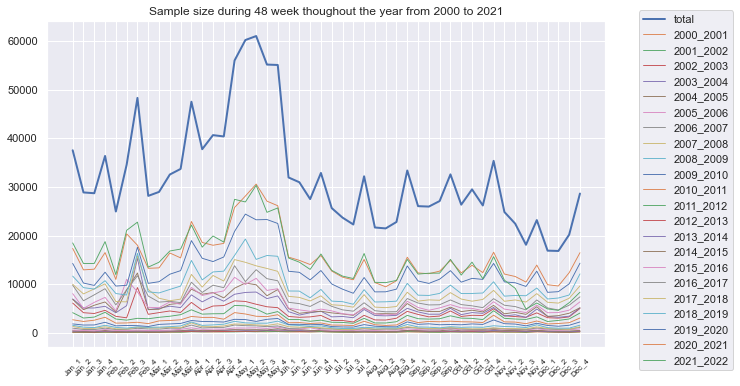

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(df_migration["sample size:"], label="total", linewidth=2.0)

for key in dict_df.keys():
    plt.plot(
        dict_df[key].reset_index().set_index("week").drop("date", axis=1)["sample size:"], label=key, linewidth=0.9
    )

plt.title("Sample size during 48 week thoughout the year from 2000 to 2021", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.xticks(fontsize=8, rotation=45)
plt.show()

Spring especially April and May are the best months for birding, pleasant weather is one of the most important reason leads to birds' active ativities.

**<font face="Times New Roman">Easiest and hardest birds to spot</font>**

In [97]:
freq_sort_total = df_migration_total.iloc[:, 1:].mean(axis=0).sort_values()
print(f"Top 5 easiest birds to spot. \n\n{freq_sort_total.iloc[-5:]}")
print("\n")
print(f"Top 5 rarest birds to spot.\n\n{freq_sort_total.iloc[:5]}")

Top 5 easiest birds to spot. 

mourning dove             0.382968
black-capped chickadee    0.384682
american robin            0.428848
northern cardinal         0.442445
blue jay                  0.468619
dtype: float64


Top 5 rarest birds to spot.

passerina sp.               3.458333e-07
laughing/franklin's gull    3.770833e-07
south african shelduck      3.791667e-07
pheasant sp.                4.312500e-07
columba sp.                 4.375000e-07
dtype: float64


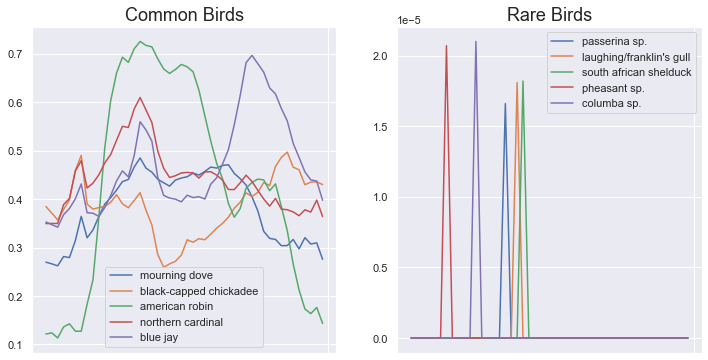

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for common_bird in freq_sort_total.iloc[-5:].index:
    axes[0].plot(df_migration_total[common_bird], label=common_bird)
axes[0].set_title('Common Birds', fontsize=18)
axes[0].set_xticks('')
axes[0].legend()

for rare_bird in freq_sort_total.iloc[:5].index:
    axes[1].plot(df_migration_total[rare_bird], label=rare_bird)
axes[1].set_title('Rare Birds', fontsize=18)
axes[1].set_xticks('')
axes[1].legend()

plt.show()

**<font face="Times New Roman">Correlation Matrix</font>**

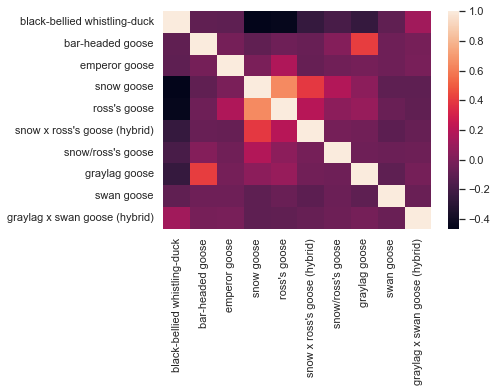

In [101]:
# calculate the correlation matrix for the first 20 species
corr = df_migration_total.iloc[:, 1:10 + 1].corr()

# plot the heatmap
sns.heatmap(
    corr, 
    xticklabels=corr.columns,
    yticklabels=corr.columns
)
plt.show()

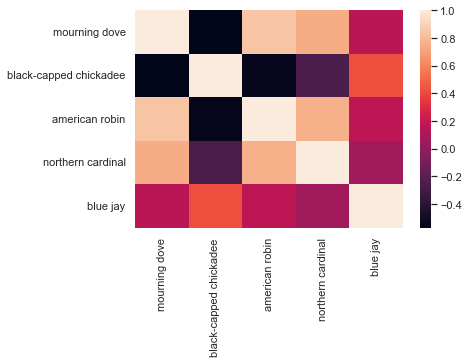

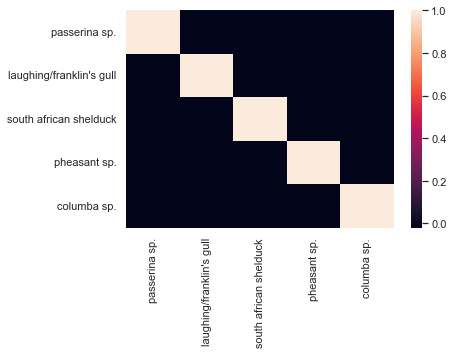

In [109]:
# calculate the correlation matrix for the rarest and easiest birds to spot.
col_top_birds = [col for col in freq_sort_total.iloc[-5:].index]
col_bot_birds = [col for col in freq_sort_total.iloc[:5].index]
corr_top = df_migration_total[col_top_birds].corr()
corr_bot = df_migration_total[col_bot_birds].corr()

sns.heatmap(
    corr_top, 
    xticklabels=corr_top.columns,
    yticklabels=corr_top.columns, 
)
plt.show()

sns.heatmap(
    corr_bot, 
    xticklabels=corr_bot.columns,
    yticklabels=corr_bot.columns,
)
plt.show()

## <font face="Times New Roman">Statistics Year by Year</font>  
TODO: Time Series Analysis, Stationarity, ACF, PACF etc.

**<font face="Time New Roman">Plot the time series</font>**

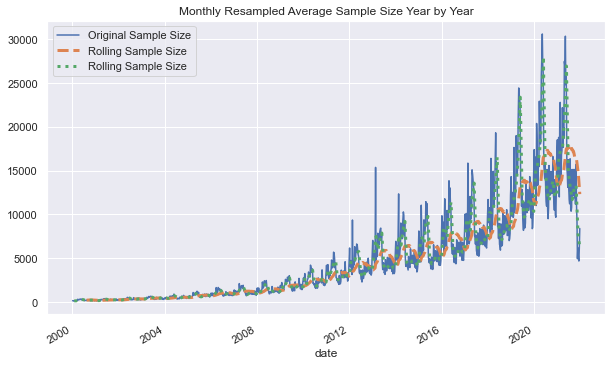

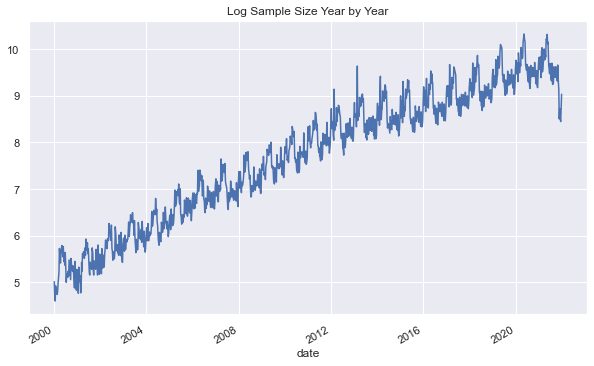

<Figure size 432x288 with 0 Axes>

In [129]:
df_migration_yoy["sample size:"].plot(
    title="Sample Size Year by Year",
    label="Original Sample Size",
    figsize=(10, 6),
    legend=True
)
df_migration_yoy["sample size:"].rolling(30).mean().plot(
    title="Monthly Rolling Average Sample Size Year by Year",
    label="Rolling Sample Size",
    linestyle="--",
    linewidth=3,
    figsize=(10, 6),
    legend=True
)
df_migration_yoy["sample size:"].resample("M").mean().plot(
    title="Monthly Resampled Average Sample Size Year by Year",
    label="Rolling Sample Size",
    linestyle=":",
    linewidth=3,
    figsize=(10, 6),
    legend=True
)
plt.show()
plt.clf()

df_migration_yoy["log sample size"] = np.log(df_migration_yoy["sample size:"].copy())
df_migration_yoy["log sample size"].plot(
    title="Log Sample Size Year by Year",
    figsize=(10, 6)
)
plt.show()
plt.clf()

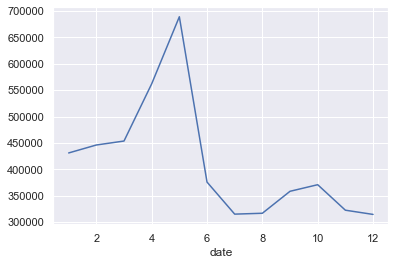

In [132]:
df_migration_yoy["sample size:"].groupby(df_migration_yoy.index.month).mean().plot();

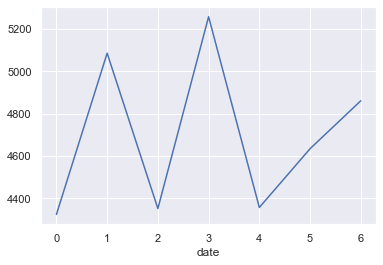

In [133]:
df_migration_yoy["sample size:"].groupby(df_migration_yoy.index.dayofweek).mean().plot();

## <font face="Times New Roman">Clusters</font>
TODO: K-means  
..

**<font face="Time New Roman">Clustering from a time series point of view</font>**

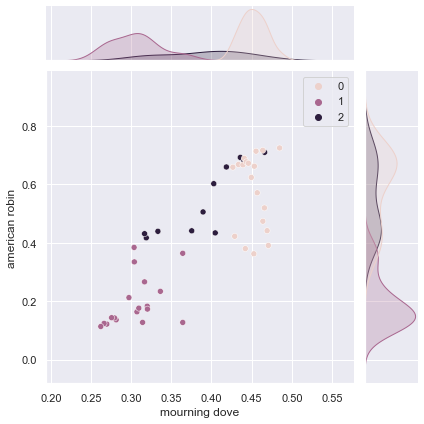

In [35]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_migration_total.iloc[:, 1:])
sns.jointplot(data=df_migration_total.iloc[:, 1:], x="mourning dove", y="american robin", hue=kmeans.labels_) #, kind="kde")
plt.show()

In [36]:
df_test = df_migration_total.reset_index()

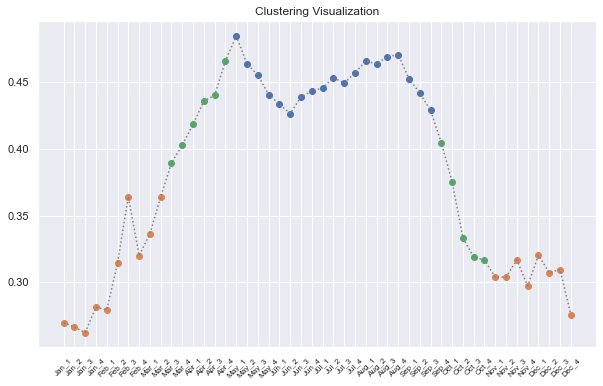

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(df_test["mourning dove"], color="grey", linestyle=":")
for i in range(3):
    series = df_test.loc[kmeans.labels_ == i, "mourning dove"]
    plt.scatter(series.index, series.values)

plt.title("Clustering Visualization", fontsize=12)
plt.xticks(range(len(df_migration.index)), df_migration.index, rotation=45, fontsize=8)
plt.show()

**<font face="Time New Roman">Clustering from a cross sectional point of view</font>**

In [18]:
# kmeans = KMeans(n_clusters=5, random_state=0).fit(df_migration.iloc[:, 1:].T)
# sns.jointplot(data=df_migration.iloc[:, 1:].T, x="May_1", y="Dec_1", hue=kmeans.labels_) #, kind="kde")